In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
import os
import time

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values of the images to the range [-1, 1]
x_train_normalized = (x_train / 127.5) - 1
x_test_normalized = (x_test / 127.5) - 1


2024-04-29 10:08:08.611075: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 10:08:08.784583: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 10:08:09.454867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 10:08:11.681437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
min(x_train_normalized.flatten()), max(x_train_normalized.flatten())

(-1.0, 1.0)

In [3]:
latent_dim = 100 
input_shape = (28, 28, 1)

In [4]:
def build_generator(latent_dim):
    model = Sequential([
        # Start with a densely connected layer taking the latent vector as input
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.01),  # LeakyReLU can help the network learn non-linear decision boundaries

        # Scale up to larger vectors with more dense layers
        Dense(256),
        LeakyReLU(alpha=0.01),

        Dense(512),
        LeakyReLU(alpha=0.01),

        Dense(1024),
        LeakyReLU(alpha=0.01),

        # Output layer: fully connected layer with output size 28*28 (MNIST image size)
        Dense(28 * 28),
        LeakyReLU(alpha=0.01),

        # Reshape output to match the 28x28 image size
        Reshape((28, 28))
    ])
    return model

generator = build_generator(latent_dim)


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
def build_discriminator(input_shape):
    model = Sequential([
        # Flatten the image input to a vector
        Flatten(input_shape=input_shape),
        
        # First dense layer
        Dense(512),
        LeakyReLU(alpha=0.2),

        # Second dense layer
        Dense(256),
        LeakyReLU(alpha=0.2),

        # Output layer with sigmoid activation to classify the image as real or fake
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator(input_shape)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Compileren van de discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [7]:
# Bouwen en compileren van het GAN-model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')
discriminator.trainable = True

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


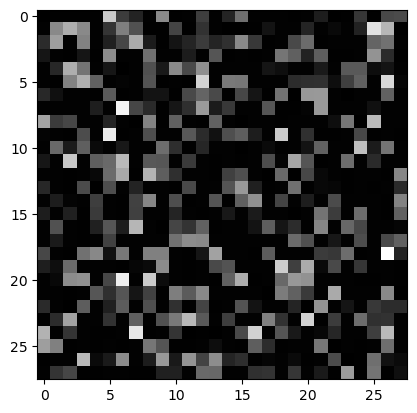

In [11]:
plt.imshow(generator.predict(np.random.randn(1, latent_dim)).reshape(28, 28), cmap='gray')

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_generated_images(epoch, generator, latent_dim, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    # Zorg ervoor dat de map 'imgs' bestaat
    if not os.path.exists('imgs'):
        os.makedirs('imgs')
    
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    
    # Sla de figuur op in de 'imgs' map
    plt.savefig(f'imgs/gan_generated_image_epoch_{epoch}.png')
    plt.close()


In [16]:
def train_gan(generator, discriminator, gan_model, epochs, batch_size, latent_dim, training_data):
    # Aantal iteraties per epoch
    batch_count = training_data.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            # Willekeurige echte afbeeldingen
            idx = np.random.randint(0, training_data.shape[0], batch_size)
            real_imgs = training_data[idx]

            # Genereer een batch met nieuwe afbeeldingen
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            # Train de discriminator (echte afbeeldingen als echt)
            d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
            # Train de discriminator (genereerde afbeeldingen als nep)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train de Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_y = np.ones((batch_size, 1))  # Labels voor gegenereerde afbeeldingen als echt door de discriminator
            g_loss = gan_model.train_on_batch(noise, valid_y)

        # Print de voortgang
        print(f"Epoch {e+1}/{epochs}")
        print(f"D Loss: {d_loss[0]}, D Acc: {100*d_loss[1]}%")
        print(f"G Loss: {g_loss}")

        # Sla afbeeldingen op elke epoch op
        plot_generated_images(e, generator, latent_dim)

In [17]:
train_gan(generator, discriminator, gan, epochs=100, batch_size=128, latent_dim=latent_dim, training_data=x_train_normalized)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━

: 